# EEG Signal Processing using Pytorch Project on CP DSAI Course

The project is to do classification on EEG signal using BCI Motor Imagery Dataset. 

In [1]:
!pip install mne

In [2]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np

from google.colab import drive

# Modeling and training packages
import torch
from torch import nn
import torch.optim as optim

# Data Preparation packages
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

#Configurations
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 1. Dataset Retrival

Because the dataset was loaded to Google drive directory, mounting that directory

In [ ]:
drive.mount('/content/drive')

MessageError: ignored

Define dataset path. The dataset path should be the path that contains **RECORDS** files and folders referring to each subject

In [4]:
dataset_path = '/content/drive/MyDrive/CourseWork Resource/CPDSAI/project/files/'

Write the function to do read preprocess and any neccessary steps fot generating raw X and y

In [5]:
class motorImagery:
    def __init__(self, path=None, subjects=[1], runs=[1]):
        self.path = path
        self.edf_filenames = self.get_filenames(path)
        self.raw = self.load_eeg(subjects, runs)
        
    def get_filenames(self, path):
        file = open(dataset_path+'RECORDS')
        edf_filenames = file.readlines()
        file.close()
        edf_filenames = [fname.rstrip() for fname in edf_filenames]
        return edf_filenames
    
    def load_eeg(self, subjects, runs):    #load -> standardize -> notch_filter -> bandpass filter -> return
    
        fno = self.get_fileIndices(subjects, runs)
        print('Loading files at index:', fno)
        
        raw_eegs = []
        for idx,i in enumerate(fno):
            path_file = os.path.join(self.path, self.edf_filenames[i])
            sys.stdout.write(f"\rLoading file #{idx+1}/{len(fno)}: {path_file}")
            raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
            raw_eegs.append(raw)

        raw = mne.io.concatenate_raws(raw_eegs)     # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        return raw                                  
    
    def get_fileIndices(self, subjects, runs):
        fno = []
        subjects = [s-1 for s in subjects]  # start from 0, 1, 2, ...
        for subject in subjects:
            for run in runs:
                fno.append(subject*14+run-1)   # 14 runs per subject
        return fno
    
    def apply_filter(self, freq):
        # Remove power line noise atrifacts at 50 Hz <-- European data so 50Hz powerline freq
        #self.raw.notch_filter(50)
        # Remove higher frequencies as they are redundant for analysis.
        low_freq, high_freq = freq
        self.raw.filter(low_freq, high_freq, fir_design='firwin')
        
    def get_ica(self, n=16):
        self.ica = mne.preprocessing.ICA(n_components=n, max_iter='auto', random_state=97)
        self.ica.fit(self.raw)
        self.raw.load_data()
        self.ica.plot_sources(self.raw)
        self.ica.plot_components()
        
    def exclude_ic(self, channels):
        self.ica.exclude = channels
        self.ica.apply(self.raw)

    def get_events(self):
        event_id = dict(T1=2, T2=3)        # Define the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        # We don't need it for now but lets include it as it is a part of the pipeline of eeg classification
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')

        # tmin and tmax are relative to the event onset time. They decide the time interval (relative to event onset) taken to 
        # form the epoch from eeg signal. 
        tmin = -1  # A second before event cue 
        tmax = 4   # Four seconds after cue. Most events are of 4.1 or 4.2 seconds long as described in annotations.

        # Read epochs (only the events described in our event_id will be included for training)
        # For future try to use baseline subtraction method 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)

        # Only eeg signals in time interval 1-2 sec will be used for training -> 1 sec after event cue to 2 sec after cue.
        # This is to avoid the evoked potentials arising in brain in response to event cue.
        epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
        montage = mne.channels.make_standard_montage('standard_1005')
        epochs_train.set_montage(montage)
        
        return epochs_train
    
    def downsample(self, epochs, factor):
        return epochs.decimate(factor)
        
    def return_epochs(self, freq=(1, 40), dsamplingFactor=1, channel_selection=False):
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        self.epochs = self.downsample(self.epochs, dsamplingFactor)
        self.labels = self.epochs.events[:,-1] - 2        # Convert from 2,3 to 0,1 and assign to labels for training
        if channel_selection:
            self.epochs = self.epochs.pick_channels(self.epochs.ch_names[:21])
        return self.epochs, self.labels
    
    def get_X_y(self, channel_selection=False):
        self.return_epochs(channel_selection=channel_selection)
        return self.epochs.get_data(), self.labels

To get X and y of Dataset, just simply implement the function

In [6]:
# Define subject list and runs number
subjects = [i for i in range(1, 11)]
runs = [6,10,14]
freq_select = (1,40)

# initialize dataset
eeg = motorImagery(dataset_path, subjects, runs)

# do filtering frequency
eeg.apply_filter(freq=freq_select)

# gather X and y
X, y = eeg.get_X_y(channel_selection=False)

X.shape

Loading files at index: [5, 9, 13, 19, 23, 27, 33, 37, 41, 47, 51, 55, 61, 65, 69, 75, 79, 83, 89, 93, 97, 103, 107, 111, 117, 121, 125, 131, 135, 139]
Loading file #30/30: /content/drive/MyDrive/CourseWork Resource/CPDSAI/project/files/S010/S010R14.edfUsed Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
450 matching events found
No baseline correction applied
0 projection items activated
Loading data for 450 events and 801 original time points ...
0 bad epochs dropped


(450, 64, 161)

# 2. Data Preprocessing

This is to prepare CNN data form (if implementing RNN, deactivate this cell)

In [7]:
X = X[:, np.newaxis,:,:]
X.shape

(450, 1, 64, 161)

In [ ]:
plt.plot(X[0,0,0,:])
plt.title('Example eeg signal')
plt.xlabel('time')
plt.ylabel('amplitude ($\mu V$)' )
plt.show()

**Wavelet Transform**

Wavelet transform will generate amplitude values corespoding with specific frequency for continuous times

From CNN input (raw EEG) shape **(batch size, time sequence, channels)** will be transformed to **(batch size, channels, frequency range (height of image), time sequence (width of image))**

In [8]:
def wavelet_transform(X, freq_arange):

    transformed_X = np.zeros((X.shape[0], X.shape[2], max(freq_arange), X.shape[-1]))

    for x_i in range(X.shape[0]):

        for chan_i in range(X.shape[2]):

            transformed_X[x_i, chan_i,:,:] = signal.cwt(X[x_i, 0, chan_i, :], signal.ricker, freq_arange)

    return transformed_X

After define function to transform, perform it

In [9]:
X_cwt = wavelet_transform(X, np.arange(1, 41)) # frequency range is 1 - 40

The transformed shape will be **(batch size, channels, freq_range, time_seq)**

In [10]:
X_cwt.shape

(450, 64, 40, 161)

Example of batch 0 and channel 0 will be

Text(0.5, 1.0, 'Example of CWT eeg signal of batch 0 and channel 0')

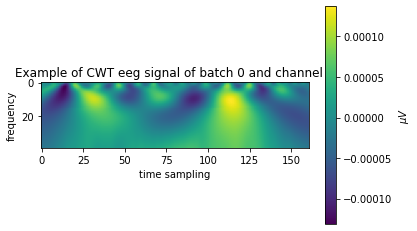

In [11]:
plt.imshow(X_cwt[0,0])
plt.colorbar(label='$\mu V$')
plt.ylabel('frequency')
plt.xlabel('time sampling')
plt.title('Example of CWT eeg signal of batch 0 and channel 0')

This is to prepare RNN data form (if implementing CNN, deactivate this cell)

In [ ]:
# X = np.transpose(X, (0,2,1))
# X.shape

Due to small value of EEG signal regarding to X. the values will be scaled up. Actually, the signal values are the micro volt ($10^{-6}$) unit converted to volt. So that, the value should be rescaled to micro volt again to a scale of a unit of +1.0 or -1.0.

In [12]:
X = X_cwt *10000
X[0]

array([[[-6.36487741e-02,  1.30714035e-02,  1.36080800e-01, ...,
          7.59546348e-02, -9.30841257e-02, -2.09077231e-01],
        [ 1.83103622e-02,  3.76755917e-02,  7.76298031e-03, ...,
          2.49625999e-02, -1.33043329e-01, -2.04979769e-01],
        [ 1.55714216e-02,  1.19187301e-02,  1.93990860e-02, ...,
         -1.47080838e-01, -1.56111793e-01, -1.40810733e-01],
        ...,
        [-3.04806860e-01, -2.89976307e-01, -2.80220546e-01, ...,
         -2.79406874e-01, -2.92254059e-01, -3.12944198e-01],
        [-2.87960845e-01, -2.72910722e-01, -2.63207637e-01, ...,
         -2.50323352e-01, -2.63057039e-01, -2.84044543e-01],
        [-2.71375360e-01, -2.56158490e-01, -2.46514363e-01, ...,
         -2.22279049e-01, -2.34840263e-01, -2.55996231e-01]],

       [[-6.43400349e-02, -3.11439098e-02,  1.31594455e-01, ...,
          1.64577292e-02, -1.81089743e-01, -3.04866928e-01],
        [ 2.63273462e-02, -9.93867076e-04, -6.57016332e-02, ...,
         -2.26837385e-01, -3.84890678e

Next function is to prepare X and y as numpy array into pytorch DataLoader

In [13]:
def Xy_dataloader(X_numpy, y_numpy, batch_size=32):
    
    X_tensor = torch.tensor(X_numpy).float()
    y_tensor = torch.tensor(y_numpy).long()
    
    dataset = TensorDataset(X_tensor, y_tensor)

    loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    
    return loader

Before Loading data into DataLoader, split X and y into train set and test (validation) set.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Load training set and test set for DataLoader

In [15]:
train_loader = Xy_dataloader(X_train, y_train, 32)
test_loader = Xy_dataloader(X_test, y_test, 32)

# 3. Modeling

Modeling section will make 2 Model set including RNN based and CNN based. 

In [17]:
class RNNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        
        #[batch size, seq len, embed dim]
        out, (x, _) = self.rnn(x)  #if no h0, all zeroes

        x = self.fc(x.squeeze(0))
        
        return x.squeeze(1)

In [41]:
class CNNModel(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(input_dim[1], 128, kernel_size=(3, 3), stride=1, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2,2))
        
        self.conv2 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1, padding=1),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2,2))
        
        self.conv3 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=(3, 3), stride=1, padding=1),
                                  nn.BatchNorm2d(512),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2,2))
        
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(512 * 5 * 20, 1024)
        self.fc2 = nn.Linear(1024, 2)
        
    def forward(self, x):
        # print(x.shape)
        #[batch size, seq len, embed dim]

        x = self.conv1(x)  #if no h0, all zeroes
        # print(x.shape)
        x = self.dropout(x)

        x = self.conv2(x)
        # print(x.shape)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.dropout(x)
        # print(x.shape)

        x = x.reshape(x.size(0),-1)
        # print(x.shape)

        x = self.dropout(x)
        x = self.fc1(x)
        
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# 4. Training Model

Before constructing model instance, check wheter GPU is work or not

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('pytorch is using: ', device)

pytorch is using:  cuda


In [50]:
device = 'cpu'

Create Model instance

In [42]:
# model = RNNModel(X.shape[2], 64, len(np.unique(y))).to(device)
model = CNNModel(X.shape, len(np.unique(y))).to(device)

Define Optimizer and Loss function

In [43]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Define Xavier initialization which helps init weight better to prevent model training from gradient vanishing or exploding

In [44]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here
                
model.apply(initialize_weights)

CNNModel(
  (conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=51200, out_features=1024, bias=True)
 

Lets define the training function with validation set

In [45]:
def train_model(model, train_dataloader, valid_dataloader, 
                epochs, criterion, optimizer, print_epoch=1000):
    
    loss_train = []
    loss_valid = []
    acc_train = []
    acc_valid = []
    
    for i in range(1, epochs+1):
        
        # ===================TRAIN ======================
        model.train()
        
        epoch_loss = 0
        correct = 0
        
        for x, y in train_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        acc_train.append(100 * correct / len(train_dataloader.dataset))
        loss_train.append(epoch_loss/len(train_dataloader))
        # loss_train.append(epoch_loss)
        
        # ===================VALIDATION =================
        model.eval()
    
        epoch_loss = 0
        correct = 0
        
        for x, y in valid_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
        
        acc_valid.append(100 * correct / len(valid_dataloader.dataset))
        loss_valid.append(epoch_loss/len(valid_dataloader))
        # loss_valid.append(epoch_loss)
        
        # ================= PRINT ===========================
        if i % print_epoch == 0 :
            clear_output(wait=True)
            print(f'epoch {i}/{epochs} train loss: {np.round(loss_train[-1],5)} train acc: {np.round(acc_train[-1],5)} validation loss: {np.round(loss_valid[-1],5)} validation acc: {np.round(acc_valid[-1],5)}')
            plt.plot(loss_train, label='train')
            plt.plot(loss_valid, label='test')
            plt.title('Loss during Training')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()

            plt.plot(acc_train, label='train')
            plt.plot(acc_valid, label='test')
            plt.title('Accuracy during Training')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.show()    
            
    return model, loss_train, loss_valid, acc_train, acc_valid
            

Train model

epoch 200/200 train loss: 1.10351 train acc: 86.34921264648438 validation loss: 7.73422 validation acc: 51.85184860229492


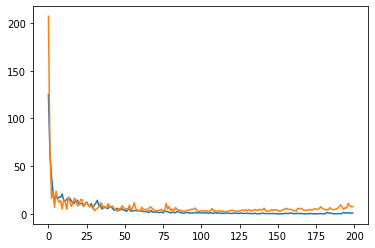

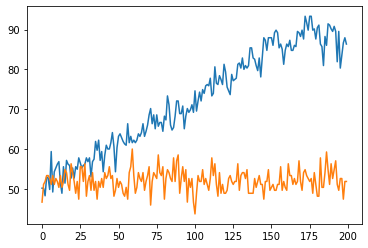

In [46]:
model, loss_train, loss_valid, acc_train, acc_valid = train_model(model, train_loader, test_loader, 200, criterion, optimizer, 10)

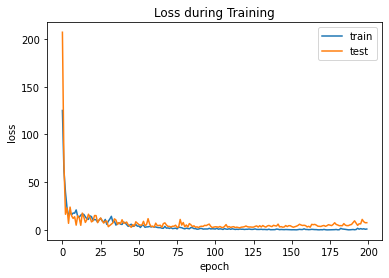

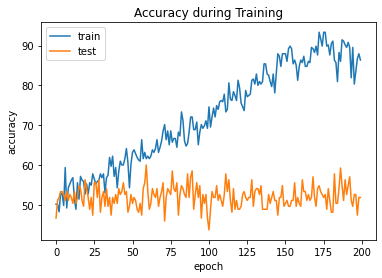

In [53]:
plt.plot(loss_train, label='train')
plt.plot(loss_valid, label='test')
plt.title('Loss during Training')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.plot(acc_train, label='train')
plt.plot(acc_valid, label='test')
plt.title('Accuracy during Training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 5. Model Evaluation

In [47]:
def predict_model(model, X_test):
    
    model.eval()
    
    x = torch.tensor(X_test).float()
    
    x = x.to(device)
            
    out = model(x).to('cpu')
    
    pred = torch.max(out, 1)[1].numpy()
    
    return pred

In [48]:
y_pred = predict_model(model, X_test)

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.30      0.38        67
           1       0.52      0.74      0.61        68

    accuracy                           0.52       135
   macro avg       0.52      0.52      0.49       135
weighted avg       0.52      0.52      0.49       135



Unmount the drive

In [1]:
drive.flush_and_unmount()

NameError: ignored